In [1]:
import raw_data
import ta

import math
import time

from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

pd.set_option("display.max_columns", 60)
tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
daily_adjusted_df = raw_data.get_time_series_daily_adjusted("amzn")
prediction_period = 1  # Predict 1 day into the future
saved_models_root = "saved_models/"

display.display(daily_adjusted_df.describe())
display.display(daily_adjusted_df.head(5))

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
count,5364.000000,5364.000000,5364.000000,5364.000000,5364.000000,5.364000e+03,5364.0,5364.000000
mean,240.724858,243.618359,237.601025,240.762875,233.256648,6.498414e+06,0.0,1.000746
std,349.628131,352.299262,346.304072,349.523822,352.908840,5.437476e+06,0.0,0.033440
min,5.910000,6.100000,5.510000,5.970000,1.395800,4.060000e+04,0.0,1.000000
25%,40.357500,41.250000,39.707500,40.380000,36.092500,3.477399e+06,0.0,1.000000
50%,86.410000,88.530000,84.410000,86.445000,74.935000,5.432310e+06,0.0,1.000000
75%,271.552500,275.864925,269.427500,273.380000,270.512500,7.951100e+06,0.0,1.000000
max,2038.110000,2050.500000,2013.000000,2039.510000,2039.510000,1.043292e+08,0.0,3.000000


,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2018-09-06,2006.505,2007.50,1935.37,1943.68,1943.68,5088733,0.0,1.0
1,2018-09-05,2038.110,2040.38,1989.89,1994.82,1994.82,8220576,0.0,1.0
2,2018-09-04,2026.500,2050.50,2013.00,2039.51,2039.51,5721093,0.0,1.0
3,2018-08-31,2007.000,2022.38,2004.74,2012.71,2012.71,4204378,0.0,1.0
4,2018-08-30,1997.420,2025.57,1986.90,2002.38,2002.38,7277257,0.0,1.0


In [3]:
def preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period, selected_features=None):
    base_features = daily_adjusted_df[[
        "open",
        "high",
        "low",
        "adjusted_close",
        "volume"
    ]]

    # Truncate the most recent prediction_period days, since we don't have their target values
    processed_df = base_features.iloc[prediction_period:].copy()
    
    # Add technical indicators
    ta.add_all_ta_features(processed_df, "open", "high", "low", "adjusted_close", "volume", fillna=True)
    
    if selected_features is None:
        # Drop features with very low variance
        original_num_features = processed_df.shape[1]
        processed_df = processed_df.loc[:, processed_df.std() > 0.01]
        print("Dropped {} features.".format(original_num_features - processed_df.shape[1]))
    else:
        processed_df = processed_df.loc[:, selected_features]
    
    # Add the target column
    if prediction_period == 0:
        processed_df["future_percent_change"] = 0
    else:
        start_adjusted_closes = daily_adjusted_df["adjusted_close"].iloc[prediction_period:].values
        end_adjusted_closes = daily_adjusted_df["adjusted_close"].iloc[:-prediction_period].values
        processed_df["future_percent_change"] = (end_adjusted_closes - start_adjusted_closes) / start_adjusted_closes * 100.0
        
    return processed_df

In [4]:
def preprocess_features(df, means=None, stds=None):
    processed_features = df.iloc[:, df.columns != "future_percent_change"].copy()

    # Normalize features
    calculated_stats = False
    if means is None:
        means = processed_features.mean()
        calculated_stats = True
    if stds is None:
        stds = processed_features.std()
        calculated_stats = True
    processed_features = (processed_features - means) / stds
    
    if calculated_stats:
        return processed_features, means, stds
    return processed_features

def preprocess_targets(df):
    processed_targets = df["future_percent_change"].copy()
    return processed_targets

In [5]:
df = preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period)
display.display(df.describe())
display.display(df.head(5))

Dropped 2 features.


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_percent_change
count,5363.000000,5363.000000,5363.000000,5363.000000,5.363000e+03,5.363000e+03,5.363000e+03,5.363000e+03,5363.000000,5.363000e+03,5.363000e+03,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000
mean,240.395606,243.289460,237.284454,232.937717,6.498677e+06,-1.317551e+07,-7.814342e+03,-7.386093e+03,-2.335701,1.815013e+06,1.743191e+03,212.384379,14.617989,251.669755,220.934387,236.302071,0.040462,0.071042,239.445071,245.467348,233.422795,0.108148,249.136993,223.450431,0.095655,0.161290,-4.826025,-4.830128,0.004103,237.291795,242.117820,32.562951,16.113015,19.352859,0.408354,0.713826,0.767221,0.205579,-0.129267,24.896435,-15.195377,0.507175,-14.740626,-14.614204,-0.126422,251.738127,258.639569,46.013713,49.789906,-7.589525,44.908315,17.604499,17.636746,-82.395501,-4.962742,-0.058678,-0.129148,-88.322870,0.200177
std,348.828071,351.507557,345.559274,352.167812,5.437949e+06,5.360891e+07,8.456715e+06,2.409831e+06,7.964886,6.382388e+07,6.055114e+05,264.542383,25.018228,377.171218,340.640421,358.718808,0.197060,0.256919,352.767405,358.719631,346.864326,0.310597,373.973119,343.713748,0.294146,0.367833,12.482980,12.047316,3.101749,360.746193,369.176711,10.013531,8.751718,9.833603,0.491575,0.257137,0.260141,0.157934,0.563438,1.149886,87.450243,9.026338,134.546016,131.478364,43.042878,369.299695,379.742527,11.823260,13.400876,15.204053,16.559572,103.632340,102.431745,103.632340,21.777497,3.741827,3.763509,17.654115,3.820145
min,5.910000,6.100000,5.510000,1.395800,4.060000e+04,-5.795261e+08,-1.043292e+08,-1.272262e+07,-48.756969,-1.015144e+09,-1.417302e+07,0.043194,0.805838,1.657439,1.054363,1.531875,0.000000,0.000000,6.587667,7.378333,5.784667,0.000000,1.687500,1.395800,0.000000,0.000000,-81.794826,-74.990637,-18.205707,1.583921,1.844874,10.722179,0.000000,0.209474,0.000000,0.029056,0.032817,0.000000,-2.778932,19.780102,-254.272762,-107.454500,-547.177024,-529.579589,-234.060690,7.210000,7.750000,15.875302,9.223969,-47.107398,-4.237057,-923.811429,-847.172143,-1023.811429,-141.560941,-25.634726,-29.618110,-99.930029,-24.766064
25%,40.355000,41.250000,39.705000,36.085000,3.476622e+06,-4.957312e+06,-5.347900e+06,-1.199293e+06,-0.092998,-2.197587e+06,-1.017170e+05,14.424463,1.878694,40.483831,32.682079,36.378750,0.000000,0.000000,39.408908,40.991513,37.904667,0.000000,39.750000,33.830000,0.000000,0.000000,-5.544729,-5.447286,-0.790958,36.553638,36.895535,25.041836,9.767433,12.529441,0.000000,0.627797,0.703329,0.068563,-0.401265,24.245883,-83.533048,-1.649500,-82.286007,-81.857964,-21.255427,41.283750,41.975000,37.478608,40.550269,-19.680014,44.883716,12.920918,15.425130,-87.079082,-8.203848,-1.537627,-1.549571,-98.191065,-1.370099
50%,86.41

,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_percent_change
1,2038.11,2040.38,1989.89,1994.82,8220576,0.000000e+00,0,0.0,0.0,0.00,0.000000,1000.000000,50.490000,2030.667016,1821.321984,1925.9945,0.0,0.0,1961.034333,1989.714333,1932.354333,0.0,2039.51,1876.71,0.0,0.0,0.000000,0.000000,0.000000,1994.820000,1994.820000,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,1860.9275,1848.405,50.000000,50.0,0.000000,50.0,50.0,50.0,-50.0,0.0,0.000000,0.000000,0.000000,-2.563640
2,2026.50,2050.50,2013.00,2039.51,5721093,-4.247441e+06,5721093,0.0,0.0,0.00,0.000000,1022.403024,53.174483,2030.667016,1821.321984,1925.9945,0.0,0.0,1961.034333,1989.714333,1932.354333,0.0,2039.51,1876.71,0.0,0.0,0.472196,0.248524,0.223672,2018.058800,2017.586604,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,1860.9275,1848.405,100.000000,50.0,100.000000,50.0,50.0,50.0,-50.0,0.0,2.240302,2.215576,2.240302,-2.191213
3,2007.00,2022.38,2004.74,2012.71,4204378,1.962586e+06,-4204378,0.0,0.0,-71849782.22,72922.527158,1008.968228,46.611870,2030.667016,1821.321984,1925.9945,0.0,0.0,1961.034333,1989.714333,1932.354333,0.0,2039.51,1876.71,0.0,0.0,0.232057,0.242448,-0.010391,2016.131407,2015.899350,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,1860.9275,1848.405,60.882004,50.0,64.543416,50.0,50.0,50.0,-50.0,0.0,-1.314041,-1.322751,0.896823,1.331538
4,1997.42,2025.57,1986.90,2002.38,7277257,-1.856119e+06,-7277257,0.0,0.0,-57780369.32,-92596.930883,1008.968228,44.416456,2030.667016,1821.321984,1925.9945,0.0,0.0,1961.034333,1989.714333,1932.354333,0.0,2039.51,1876.71,0.0,0.0,-0.055372,0.155847,-0.211219,2012.270469,2012.325841,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,1860.9275,1848.405,52.414477,50.0,48.784253,50.0,50.0,50.0,-50.0,0.0,-0.513238,-0.514560,0.378982,0.515886
5,1953.45,1998.69,1948.94,1998.10,6531761,4.925902e+06,-6531761,0.0,0.0,-34003065.63,-51311.029747,1006.811602,46.478360,2030.667016,1821.321984,1925.9945,0.0,0.0,1961.034333,1989.714333,1932.354333,0.0,2039.51,1876.71,0.0,0.0,-0.296413,0.045408,-0.341821,2008.965558,2009.261970,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,1860.9275,1848.405,49.366533,50.0,39.892928,50.0,50.0,50.0,-50.0,0.0,-0.213746,-0.213974,0.164426,0.214203


In [6]:
# Use 85% for training, 10% for validation, and most recent 5% for testing
num_rows = len(df)
num_training = int(num_rows * 0.85)
num_validation = int(num_rows * 0.1)
num_testing = num_rows - num_training - num_validation

# Shuffle before splitting into training and validation sets
training_and_validation_df = df.tail(num_training + num_validation).sample(frac=1)

training_df = training_and_validation_df.head(num_training)
training_examples, feature_means, feature_stds = preprocess_features(training_df)
training_targets = preprocess_targets(training_df)

validation_df = training_and_validation_df.tail(num_validation)
validation_examples = preprocess_features(validation_df, feature_means, feature_stds)
validation_targets = preprocess_targets(validation_df)

testing_df = df.head(num_testing)
testing_examples = preprocess_features(testing_df, feature_means, feature_stds)
testing_targets = preprocess_targets(testing_df)

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())
print("Testing examples summary:")
display.display(testing_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())
print("Testing targets summary:")
display.display(testing_targets.describe())

Training examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03
mean,-5.206698e-15,-7.856813e-16,-3.744457e-15,-9.197460e-16,-8.418014e-17,7.326790e-17,1.403002e-17,6.235566e-18,-3.452945e-16,-1.403002e-17,-2.338337e-17,-3.055427e-16,-8.379042e-16,-1.231524e-15,3.928407e-16,9.353349e-18,1.091224e-17,4.053118e-17,1.696074e-15,-1.820785e-15,-1.300115e-15,-5.845843e-17,3.304850e-16,2.039030e-15,-3.429561e-17,3.117783e-18,-8.807737e-16,-7.997113e-16,1.403002e-17,-7.420323e-16,-2.307159e-16,-5.962760e-16,-2.325087e-15,-3.368570e-15,-6.235566e-17,2.552685e-15,-1.882361e-16,2.603349e-16,-2.735855e-16,2.970390e-14,-3.655601e-16,-1.340647e-16,8.885681e-17,4.754619e-17,1.013279e-17,7.071132e-15,2.057737e-16,-1.697945e-14,-7.236374e-15,-4.255774e-16,-4.815416e-15,1.465358e-16,-5.300231e-17,-3.677425e-15,-7.794457e-18,-3.741340e-17,-3.039838e-17,-1.564192e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-7.868623e-01,-7.917641e-01,-7.838020e-01,-7.596834e-01,-1.187084e+00,-1.029405e+01,-1.209541e+01,-5.205392e+00,-5.600989e+00,-1.313952e+01,-2.270378e+01,-7.851203e-01,-5.107231e-01,-7.759808e-01,-7.403390e-01,-7.587644e-01,-2.136414e-01,-2.719753e-01,-7.689908e-01,-7.761809e-01,-7.614408e-01,-3.623110e-01,-7.743600e-01,-7.439113e-01,-3.309355e-01,-4.241138e-01,-4.335724e+00,-4.616829e+00,-5.926913e+00,-7.588425e-01,-7.572906e-01,-2.188716e+00,-1.824825e+00,-1.910094e+00,-8.580323e-01,-2.595873e+00,-2.731490e+00,-1.298915e+00,-4.592106e+00,-4.111520e+00,-2.738619e+00,-9.373828e+00,-3.864583e+00,-3.826346e+00,-5.286804e+00,-7.805681e-01,-7.794075e-01,-2.609986e+00,-3.010563e+00,-2.724070e+00,-2.861816e+00,-8.708052e+00,-8.090762e+00,-8.708052e+00,-5.536226e+00,-6.712706e+00,-7.697909e+00,-7.596834e-01
25%,-6.345422e-01,-6.378184e-01,-6.309807e-01,-6.072164e-01,-5.517537e-01,1.595050e-01,-6.

Validation examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000
mean,0.052049,0.052302,0.051353,0.053829,-0.026228,0.011262,0.031323,0.012205,0.063326,0.010174,-0.063158,0.074812,0.000441,0.052184,0.053951,0.053070,-0.058442,0.044746,0.052110,0.052769,0.051422,-0.065277,0.053850,0.054573,0.006767,0.074057,-0.033848,-0.020672,-0.043408,0.053722,0.053956,0.040752,0.051815,0.005270,0.006372,0.053204,0.065047,0.000153,-0.043185,-0.044660,-0.026992,0.037317,-0.058312,-0.053381,-0.019302,0.055495,0.051056,-0.018379,0.003109,0.004529,0.049296,0.064275,0.063880,0.064275,-0.041338,-0.008843,-0.009798,0.053829
std,1.019723,1.021714,1.018534,1.020805,0.972714,0.993738,0.976545,0.990238,0.873147,0.575941,0.936390,1.023970,1.075901,1.015067,1.015463,1.015409,0.858332,1.073427,1.016896,1.018638,1.015080,0.916847,1.016543,1.016088,1.009872,1.067516,1.016661,1.030199,1.079935,1.015910,1.014514,1.005685,0.979941,0.931358,1.001783,0.933427,0.928151,0.960863,0.951378,0.975817,1.005474,0.947828,0.925551,0.930313,0.925202,1.017080,1.011836,0.957134,0.998722,0.923073,0.919734,0.824169,0.824258,0.824169,1.104291,1.023361,1.028201,1.020805
min,-0.784300,-0.789309,-0.783064,-0.756160,-1.173496,-8.880664,-6.760208,-4.120789,-4.892482,-2.999412,-6.751907,-0.784993,-0.510826,-0.772499,-0.737364,-0.755582,-0.213641,-0.271975,-0.768720,-0.776236,-0.760835,-0.362311,-0.770952,-0.740915,-0.330936,-0.424114,-4.215802,-4.129639,-5.948737,-0.755526,-0.753714,-2.078381,-1.778013,-1.825782,-0.858032,-2.545215,-2.686558,-1.296290,-4.048493,-4.027950,-2.606826,-4.575730,-3.171723,-3.211026,-5.040307,-0.778648,-0.779408,-2.542147,-3.077305,-2.576032,-2.756427,-5.575056,-5.628990,-5.575056,-4.886641,-6.581401,-7.522855,-0.756160
25%,-0.620665,-0.621347,-0.617577,-0.600354,-0.547913,0.160700,-0.596517,-0.474475,0.293791,-0.064168,-0.221499,-0.719141,-0.467102,-0.606254,-0.587811,-0.596302,-0.213641,-0.271975,-0.616396,-0.621292,-0.610929,-0.362311,-0.605605,-0.591168,-0.330936,-0.424114,-0.244788,-0.248175,-0.376287,-0.596939,-0.598175,-0.749824,-0.665502,-0.626084,-0.858032,-0.254979,-0.194014,-0.873902,-0.471197,-0.583898,-0.805919,-0.321110,-0.524452,-0.473550,-0.433657,-0.625348,-0.627638,-0.748894,-0.632566,-0.720320,0.018971,-0.033867,0.012216,-0.033867,-0.298164,-0.452574,-0.435270,-0.600354
50%,-0.401634,-0.402870,-0.406017,-0.415059,-0.223582,0.254043,0.048475,0.009421,0.309113,-0.029783,-0.029654,-0.588097,-0.332043,-0.416319,-0.427043,-0.422000,-0.213641,-0.271975,-0.419230,-0.410581,-0.421324,-0.362311,-0.410819,-0.430951,-0.330936,-0.424114,0.229255,0.233262,-0.040829,-0.420746,-0.427086,-0.098746,0.034428,0.005977,-0.858

Testing examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,2.690000e+02,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000
mean,5.602207,5.611790,5.592506,5.553693,-0.411088,0.267658,-0.104140,-0.371620,0.316073,-0.003826,-0.044352,2.925546,0.933855,5.690874,5.557979,5.631833,-0.195451,0.080260,5.633474,5.652773,5.612514,-3.623110e-01,5.690974,5.599786,-0.218787,0.341045,-5.328489,-5.399036,-0.502988,5.663723,5.746801,1.064889,-0.293158,0.938015,-0.647435,-0.011488,0.571819,0.297182,-0.202989,-0.315136,-0.477658,0.704315,-0.267948,-0.265720,-0.026292,5.845230,5.914376,-0.837878,-0.739023,-1.188576,0.331671,0.180946,0.182000,0.180946,-2.783379,-0.055246,-0.039398,5.553693
std,1.426956,1.431749,1.423211,1.405662,0.403074,0.083615,0.555002,0.498403,0.013826,2.674268,0.206084,0.421439,0.521104,1.387118,1.394036,1.383679,0.298353,1.127507,1.417417,1.425977,1.410749,5.561462e-17,1.401093,1.405372,0.603906,1.244404,2.852240,2.880659,3.507546,1.382116,1.296175,1.058768,0.662984,0.812206,0.618999,0.576062,0.424606,1.205030,0.325527,1.624050,0.760241,4.459202,0.325659,0.328373,0.441418,1.255360,1.112456,0.881230,0.818165,0.989780,0.295164,0.233226,0.218553,0.233226,3.026655,0.422598,0.424739,1.405662
min,3.487758,3.493800,3.490024,3.464574,-0.914347,-0.019530,-1.897759,-2.164125,0.292286,-17.745406,-0.967816,2.202496,0.139379,3.439178,3.505182,3.538859,-0.213641,-0.271975,3.535426,3.518771,3.550196,-3.623110e-01,3.448764,3.604332,-0.330936,-0.424114,-10.422622,-9.945305,-7.439732,3.537279,3.598655,-0.513960,-1.604741,-1.441233,-0.858032,-1.445882,-0.533367,-1.298915,-0.864635,-4.647409,-2.747420,-16.692554,-0.919536,-0.914581,-1.697860,3.444194,3.809299,-2.488596,-3.018933,-2.192857,-0.830432,-0.145165,-0.113482,-0.145165,-8.553428,-3.050443,-3.208363,3.464574
25%,4.349281,4.354841,4.376590,4.326730,-0.672216,0.226022,-0.461421,-0.660288,0.305115,-0.228463,-0.111703,2.642820,0.493762,4.338801,4.448454,4.391921,-0.213641,-0.271975,4.442810,4.441535,4.443258,-3.623110e-01,4.366050,4.475229,-0.330936,-0.424114,-7.737667,-7.896219,-2.869916,4.432501,4.609350,0.213545,-0.838911,0.323132,-0.858032,-0.414633,0.284778,-0.739049,-0.423473,-1.194084,-0.985931,-1.542204,-0.480289,-0.490580,-0.243100,4.730061,5.089881,-1.470562,-1.225804,-1.674644,0.201862,-0.018961,-0.002817,-0.018961,-4.892247,-0.277469,-0.258544,4.326730
50%,5.784985,5.800292,5.719913,5.714707,-0.528012,0.269227,-0.307525,-0.360125,0.312499,-0.030848,-0.045490,3.006459,0.894291,6.026742,5.539175,5.795663,-0.213641,-0.271975,5.771753,5.857295,5.656749,-3.623110e-01,6.027788,5.615084,-0.330936,-0.424114,-5.560781,-5.715270,-0.988357,5.846558,5.950677,0.822345,-0.332054,1.084696,-0.858032,-0.005961,0.579

Training targets summary:


count    4558.000000
mean        0.191914
std         3.887355
min       -24.766064
25%        -1.442303
50%         0.016179
75%         1.593051
max        34.471366
Name: future_percent_change, dtype: float64

Validation targets summary:


count    536.000000
mean       0.233915
std        4.020739
min      -19.333333
25%       -1.387119
50%       -0.057589
75%        1.801929
max       33.572282
Name: future_percent_change, dtype: float64

Testing targets summary:


count    269.000000
mean       0.272951
std        1.656969
min       -5.206102
25%       -0.467201
50%        0.324802
75%        1.114796
max       13.216375
Name: future_percent_change, dtype: float64

In [7]:
print("Data for the most recent 5 days:")
display.display(testing_examples.head(5))
display.display(testing_targets.head(5))

Data for the most recent 5 days:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
1,8.512974,8.457849,8.372459,8.225271,0.287071,0.254369,-0.001187,-0.014406,0.305115,-0.030848,-0.011328,3.638410,1.495336,7.880499,7.741032,7.820057,-0.213641,-0.271975,8.100779,8.091356,8.108904,-0.362311,7.997829,7.956777,-0.330936,-0.424114,0.365887,0.393015,-0.031237,8.105945,7.959818,0.822345,0.428384,0.113755,-0.858032,1.091569,0.912117,-1.298915,0.208826,0.073393,0.146271,-0.039544,0.087191,0.089395,-0.000393,7.401402,7.152586,0.295547,-0.02101,0.452638,0.320294,0.31569,0.31887,0.31569,0.16179,0.011738,0.030745,8.225271
2,8.459844,8.503863,8.479092,8.426702,-0.163373,0.177058,0.662023,-0.014406,0.305115,-0.030848,-0.011328,3.737515,1.603731,7.880499,7.741032,7.820057,-0.213641,-0.271975,8.100779,8.091356,8.108904,-0.362311,7.997829,7.956777,-0.330936,-0.424114,0.428169,0.427277,0.059782,8.209298,8.059398,0.822345,0.428384,0.113755,-0.858032,1.091569,0.912117,-1.298915,0.208826,0.073393,0.146271,-0.039544,0.087191,0.089395,-0.000393,7.401402,7.152586,4.552777,-0.02101,7.196183,0.320294,0.31569,0.31887,0.31569,0.16179,0.599409,0.608885,8.426702
3,8.370607,8.376005,8.440979,8.305907,-0.436708,0.290092,-0.488574,-0.014406,0.305115,-1.284647,0.105429,3.678083,1.338743,7.880499,7.741032,7.820057,-0.213641,-0.271975,8.100779,8.091356,8.108904,-0.362311,7.997829,7.956777,-0.330936,-0.424114,0.396495,0.426439,-0.035466,8.200726,8.052018,0.822345,0.428384,0.113755,-0.858032,1.091569,0.912117,-1.298915,0.208826,0.073393,0.146271,-0.039544,0.087191,0.089395,-0.000393,7.401402,7.152586,1.222091,-0.02101,4.805152,0.320294,0.31569,0.31887,0.31569,0.16179,-0.332959,-0.314418,8.305907
4,8.326767,8.390509,8.358663,8.259346,0.117071,0.220584,-0.844793,-0.014406,0.305115,-1.039132,-0.159585,3.678083,1.250096,7.880499,7.741032,7.820057,-0.213641,-0.271975,8.100779,8.091356,8.108904,-0.362311,7.997829,7.956777,-0.330936,-0.424114,0.358584,0.414500,-0.117189,8.183555,8.036387,0.822345,0.428384,0.113755,-0.858032,1.091569,0.912117,-1.298915,0.208826,0.073393,0.146271,-0.039544,0.087191,0.089395,-0.000393,7.401402,7.152586,0.501127,-0.02101,3.742426,0.320294,0.31569,0.31887,0.31569,0.16179,-0.122894,-0.103526,8.259346
5,8.125549,8.268289,8.183509,8.240055,-0.017279,0.344029,-0.758373,-0.014406,0.305115,-0.624211,-0.093482,3.668543,1.333353,7.880499,7.741032,7.820057,-0.213641,-0.271975,8.100779,8.091356,8.108904,-0.362311,7.997829,7.956777,-0.330936,-0.424114,0.326791,0.399275,-0.170335,8.168857,8.022986,0.822345,0.428384,0.113755,-0.858032,1.091569,0.912117,-1.298915,0.208826,0.073393,0.146271,-0.039544,0.087191,0.089395,-0.000393,7.401402,7.152586,0.241611,-0.02101,3.142836,0.320294,0.31569,0.31887,0.31569,0.16179,-0.044332,-0.025090,8.240055


1   -2.563640
2   -2.191213
3    1.331538
4    0.515886
5    0.214203
Name: future_percent_change, dtype: float64

In [8]:
def construct_feature_columns(input_features):
    return [tf.feature_column.numeric_column(feature) for feature in input_features]

In [9]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(val) for key, val in dict(features).items()}

    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)

    if shuffle:
        ds = ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [10]:
def train_nn_regression_model(
    optimizer,
    steps,
    batch_size,
    batch_norm,
    dropout,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    save_model=True):
    periods = 10
    steps_per_period = steps / periods
    
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    if save_model:
        dir_name = "{}-{}".format(optimizer.get_name(), time.strftime("%Y%m%d-%H%M%S"))
        model_dir = "{}{}".format(saved_models_root, dir_name)
    else:
        model_dir = None
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        batch_norm=batch_norm,
        dropout=dropout,
        hidden_units=hidden_units,
        optimizer=optimizer,
        model_dir=model_dir)
    
    training_input_fn = lambda: input_fn(training_examples, training_targets, batch_size=batch_size)
    predict_training_input_fn = lambda: input_fn(training_examples, training_targets, num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: input_fn(validation_examples, validation_targets, num_epochs=1, shuffle=False)
    
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range(periods):
        # Train the model, starting from the prior state.
        dnn_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item["predictions"][0] for item in training_predictions])

        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item["predictions"][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_targets, training_predictions))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_targets, validation_predictions))
        # Occasionally print the current loss.
        print("  period %02d : %0.3f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.3f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.3f" % validation_root_mean_squared_error)

    return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 0.338
  period 01 : 0.175
  period 02 : 0.120
  period 03 : 0.098
  period 04 : 0.080
  period 05 : 0.070
  period 06 : 0.062
  period 07 : 0.056
  period 08 : 0.052
  period 09 : 0.051
Model training finished.
Final RMSE (on training data):   0.051
Final RMSE (on validation data): 0.105


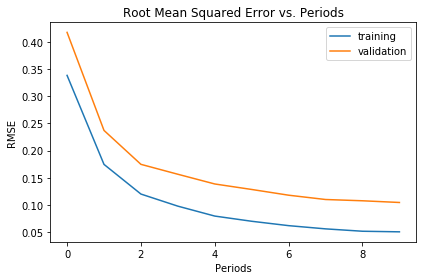

In [14]:
adam_regressor, _, _ = train_nn_regression_model(
    optimizer=tf.train.AdamOptimizer(learning_rate=0.0003),
    steps=10000,
    batch_size=128,
    batch_norm=False,
    dropout=None,
    hidden_units=[30, 20],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [ ]:
adagrad_regressor, _, _ = train_nn_regression_model(
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.007),
    steps=10000,
    batch_size=30,
    batch_norm=False,
    dropout=None,
    hidden_units=[30, 30, 20, 20, 20],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [15]:
# Select regressor to use
regressor = adam_regressor

In [17]:
# Compute stats on testing set
predict_testing_input_fn = lambda: input_fn(testing_examples, testing_targets, num_epochs=1, shuffle=False)
testing_predictions = regressor.predict(input_fn=predict_testing_input_fn)
testing_predictions = np.array([item["predictions"][0] for item in testing_predictions])

print("Stats on testing data:")

testing_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(testing_targets, testing_predictions))
print("  RMSE  : %0.3f" % testing_root_mean_squared_error)

testing_mean_absolute_error = metrics.mean_absolute_error(testing_targets, testing_predictions)
print("  MAE   : %0.3f" % testing_mean_absolute_error)

testing_median_absolute_error = metrics.median_absolute_error(testing_targets, testing_predictions)
print("  MedAE : %0.3f" % testing_median_absolute_error)

testing_r2_score = metrics.r2_score(testing_targets, testing_predictions)
print("  R^2   : %0.3f" % testing_r2_score)

Stats on testing data:
  RMSE  : 0.188
  MAE   : 0.081
  MedAE : 0.047
  R^2   : 0.987


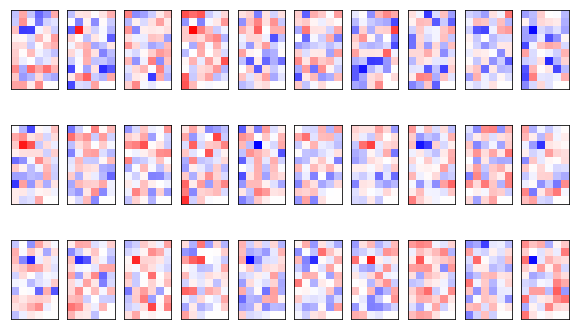

Index(['open', 'high', 'low', 'adjusted_close', 'volume', 'volume_adi',
       'volume_obv', 'volume_obvm', 'volume_cmf', 'volume_fi', 'volume_vpt',
       'volume_nvi', 'volatility_atr', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbm', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcli',
       'volatility_dch', 'volatility_dcl', 'volatility_dchi',
       'volatility_dcli', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_ema_fast', 'trend_ema_slow', 'trend_adx', 'trend_adx_pos',
       'trend_adx_neg', 'trend_adx_ind', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_a',
       'trend_ichimoku_b', 'momentum_rsi', 'momentum_mfi', 'momentum_tsi',
       'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr',
    

In [18]:
# Visualize weights from first layer
weights0 = regressor.get_variable_value("dnn/hiddenlayer_0/kernel")
num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(10, 2 * num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    # Pad with 0s at end to make length 60
    padded = np.pad(coef, (0, 60 - coef.size), "constant", constant_values=0)
    cax = ax.matshow(np.expand_dims(padded, 0).reshape(10, 6), cmap=plt.cm.bwr, vmin=-0.5, vmax=0.5)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

display.display(training_examples.columns)

In [19]:
selected_features = training_examples.columns.values
latest_df = preprocess_daily_adjusted_df(daily_adjusted_df.head(prediction_period + 365), 0, selected_features)
latest_features = preprocess_features(latest_df, feature_means, feature_stds).head(prediction_period)
latest_targets = preprocess_targets(latest_df).head(prediction_period)

predict_latest_input_fn = lambda: input_fn(latest_features, latest_targets, num_epochs=1, shuffle=False)
predictions = regressor.predict(input_fn=predict_latest_input_fn)
predictions = pd.Series([item["predictions"][0] for item in predictions])
display.display(predictions)

predictions_df = pd.DataFrame()
predictions_df["days_into_future"] = -predictions.index + prediction_period
predictions_df["close"] = latest_df["adjusted_close"].head(prediction_period) * (predictions/100.0 + 1.0)

print("Current predictions:")
display.display(predictions_df)

0   -0.108069
dtype: float64

Current predictions:


,days_into_future,close
0,1,1941.579492
